In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import (
    set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis,
    dataframe_to_ttree, ttree_to_dataframe
)
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D
from yahist.utils import clopper_pearson_error

from daskucsd.condor_utils import make_htcondor_cluster
import matplotlib.ticker

hqe = utils.hacky_query_eval

In [2]:
set_plotting_style()

In [3]:
if False:
    condorcluster = make_htcondor_cluster(local=False, dashboard_address=13345,memory="2GB")
    condorcluster.scale(50)
    condorcluster

In [4]:
if False:
    from dask.distributed import LocalCluster
    localcluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit="2GB")
    localcluster

In [5]:
if False:
    client = Client(localcluster)
    # client = Client(condorcluster)
    client

In [6]:
import uproot
import uproot_methods
import awkward
import concurrent.futures
executor = concurrent.futures.ProcessPoolExecutor(8)

def read_chunk(fname, entrystart=None, entrystop=None):
    year = 2017
    if "_2018" in fname: year = 2018
    if "DYJets" in fname: year = 2018
    if "_mzd" in fname: year = 2018
    if "darkphoton" in fname.lower(): year = 2018
    if "qcdmu15to20" in fname: year = 2018
    if "BToJpsi_ToMuMu_BMuonFilter_HardQCD" in fname: year = 2018
    if "jpsitomumu17" in fname: year = 2017
    if "jpsitomumu18" in fname: year = 2018
    if "bdtojpsi17" in fname: year = 2017
    if "bdtojpsi18" in fname: year = 2018
        
        
    t = uproot.open(fname)["Events"]
    # t["mus_p4"].keys()
    readkw = dict(entrystart=entrystart, entrystop=entrystop)
    
    try:
        fileindex = int(fname.rsplit("_",1)[-1].split(".",1)[0])
    except:
        fileindex = -1
        
    components = t.arrays(t["evt_bsp4"].keys(),outputtype=tuple,**readkw)
    bsp4s = uproot_methods.TLorentzVectorArray.from_cartesian(*components)
    bsx = bsp4s.x
    bsy = bsp4s.y
    bsz = bsp4s.z

    components = t.arrays(t["mus_p4"].keys(),outputtype=tuple,**readkw)
    mup4s = uproot_methods.TLorentzVectorArray.from_cartesian(*components)
    charges = t["mus_charge"].array(**readkw)

    selectors = t["mus_selectors"].array(**readkw)
    ismedium = ((selectors & 2) == 2)

    passhlt = t["hlt_scout_hltresult"].array(**readkw) > 0
    
    l1results = dict()

    spacing = 5000
    if entrystart is not None and entrystop is not None:
        spacing = int(max((entrystop-entrystart)//100,1))
#     print(spacing)
    setl1names = list(set(map(tuple,t["hlt_scout_l1names"].array(**readkw)[::spacing].tolist())))
#     print(setl1names)
    if len(setl1names) == 1:
        arr = t["hlt_scout_l1results"].array(**readkw)
        for iname,name in enumerate(setl1names[0]):
            l1results[name.decode()] = arr[:,iname]
    else:
        data = []
        for i,(results,names) in enumerate(
    #         tqdm(
                zip(
                    t["hlt_scout_l1results"].array(**readkw),
                    t["hlt_scout_l1names"].array(**readkw),
                )
    #         )
        ):
            data.append(dict(zip(names,results)))
        df = pd.DataFrame(data).fillna(False)
        for c in df.columns:
            l1results[c.decode()] = df[c].values
        del data

    if year == 2017:
        passl1 = l1results["L1_DoubleMu4_SQ_OS_dR_Max1p2"] | l1results["L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4"] | l1results["L1_DoubleMu_15_7"]
    elif year == 2018:
        passl1 = l1results["L1_DoubleMu4p5_SQ_OS_dR_Max1p2"] | l1results["L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4"] | l1results["L1_DoubleMu_15_7"]

    d = dict(
        p4=mup4s,
        charge=charges,
        medium=ismedium,
        hlt=passhlt,
        l1=passl1,
        bsx=bsx,
        bsy=bsy,
        bsz=bsz,
        L1_DoubleMu4_SQ_OS_dR_Max1p2=l1results["L1_DoubleMu4_SQ_OS_dR_Max1p2"],
        L1_DoubleMu4p5_SQ_OS_dR_Max1p2=l1results["L1_DoubleMu4p5_SQ_OS_dR_Max1p2"],
        L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4=l1results["L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4"],
        L1_DoubleMu_15_7=l1results["L1_DoubleMu_15_7"],
    )
    
    ks = [
        "mus_vtx_chi2",
        "mus_vtx_ndof",
        "mus_vtx_x",
        "mus_vtx_y",
        "mus_vtx_z",
        "mus_vtx_xError",
        "mus_vtx_yError",
        "mus_vtx_zError",
        "mus_dxyPV",
        "mus_mc_patMatch_vx",
        "mus_mc_patMatch_vy",
        "mus_mc_patMatch_vz",
        "mus_mc_patMatch_motherid",
        "mus_mc_patMatch_mothermass",
        "mus_massCorr",
        "evt_event",
        "evt_lumiBlock",
        "evt_run",
        "evt_nvtxs",
    ]
    for k in ks:
        shortk = k.replace("mus_","").replace("mc_patMatch","gen").replace("evt_","")
        d[shortk] = t.array(k, **readkw)
        
    d["nvtx"] = (~t["vtxs_isFake"].array(**readkw) & (t["vtxs_ndof"].array(**readkw) > 4.)).sum()
    
    table = awkward.Table(**d)

#     goodmu = (table["p4"].pt > 5) & (abs(table["p4"].eta) < 2.4) & (table["medium"])
    goodmu = (table["p4"].pt > 3) & (abs(table["p4"].eta) < 2.4) & (table["medium"])
    goodevt = (table["charge"][goodmu].counts == 2) & (table["charge"][goodmu].sum() == 0)

    df = pd.DataFrame()
    pairs = table["p4"][goodmu][goodevt].distincts()
    pairs_gen_vx = table["gen_vx"][goodmu][goodevt].distincts()
    pairs_gen_vy = table["gen_vy"][goodmu][goodevt].distincts()
    pairs_gen_vz = table["gen_vz"][goodmu][goodevt].distincts()
    pairs_gen_motherid = table["gen_motherid"][goodmu][goodevt].distincts()
    pairs_gen_mothermass = table["gen_mothermass"][goodmu][goodevt].distincts()
    pairs_dxy = table["dxyPV"][goodmu][goodevt].distincts()
    df["l1"] = table["l1"][goodevt]
    df["hlt"] = table["hlt"][goodevt]
    df["year"] = year
    df["mass"] = (pairs.i0 + pairs.i1).mass.flatten()
    df["dr"] = pairs.i0.delta_r(pairs.i1).flatten()
    df["mu1pt"] = pairs.i0.pt.flatten()
    df["mu2pt"] = pairs.i1.pt.flatten()
    df["mu1eta"] = pairs.i0.eta.flatten()
    df["mu2eta"] = pairs.i1.eta.flatten()
    df["mu1phi"] = pairs.i0.phi.flatten()
    df["mu2phi"] = pairs.i1.phi.flatten()
    df["mu1mass"] = pairs.i0.mass.flatten()
    df["mu2mass"] = pairs.i1.mass.flatten()
    df["mu1gen_vx"] = pairs_gen_vx.i0.flatten()
    df["mu2gen_vx"] = pairs_gen_vx.i1.flatten()
    df["mu1gen_vy"] = pairs_gen_vy.i0.flatten()
    df["mu2gen_vy"] = pairs_gen_vy.i1.flatten()
    df["mu1gen_vz"] = pairs_gen_vz.i0.flatten()
    df["mu2gen_vz"] = pairs_gen_vz.i1.flatten()
    df["mu1dxy"] = pairs_dxy.i0.flatten()
    df["mu2dxy"] = pairs_dxy.i1.flatten()
    df["logabsetaphi"] = np.log10(np.abs(pairs.i0.eta-pairs.i1.eta)/np.abs(pairs.i0.delta_phi(pairs.i1))).flatten()
    df["mu1gen_motherid"] = pairs_gen_motherid.i0.flatten()
    df["mu2gen_motherid"] = pairs_gen_motherid.i1.flatten()
    df["mu1gen_mothermass"] = pairs_gen_mothermass.i0.flatten()
    df["mu2gen_mothermass"] = pairs_gen_mothermass.i1.flatten()
    df["fileindex"] = fileindex
    df["entrystart"] = entrystart if entrystart is not None else -1
    df["entrystop"] = entrystop if entrystop is not None else -1
    df["bsx"] = table["bsx"][goodevt]
    df["bsy"] = table["bsy"][goodevt]
    df["bsz"] = table["bsz"][goodevt]
    df["vtx_x"] = table["vtx_x"][goodevt]
    df["vtx_y"] = table["vtx_y"][goodevt]
    df["vtx_z"] = table["vtx_z"][goodevt]
    df["vtx_xError"] = table["vtx_xError"][goodevt]
    df["vtx_yError"] = table["vtx_yError"][goodevt]
    df["vtx_zError"] = table["vtx_zError"][goodevt]
    df["vtx_chi2"] = table["vtx_chi2"][goodevt]
    df["vtx_ndof"] = table["vtx_ndof"][goodevt]
    df["nvtx"] = table["nvtx"][goodevt].astype(int)
    for k in ["massCorr","event",
            "L1_DoubleMu4_SQ_OS_dR_Max1p2",
            "L1_DoubleMu4p5_SQ_OS_dR_Max1p2",
            "L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4",
            "L1_DoubleMu_15_7",
             ]:
        df[k] = table[k][goodevt]
    for k in ["lumiBlock","run"]:
        df[k] = table[k][goodevt].astype(int)
        
    df["event"] = df["event"].astype(int)
    df["mu1mass"] = df["mu1mass"].fillna(0.105)
    df["mu2mass"] = df["mu2mass"].fillna(0.105)
    
    sel = df["massCorr"]<0.
    df.loc[sel,"massCorr"] = df.loc[sel,"mass"]
    df["mass"] = df["massCorr"]
    df = df.drop(["massCorr"],axis=1)
    
    df["recolxy"] = df.eval("((vtx_x-bsx)**2+(vtx_y-bsy)**2)**0.5")
    df["goodvtx"] = df.eval("vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11.")


    return df



In [7]:
fnames = glob.glob("/hadoop/cms/store/user/namin/BToJpsi*/*trigskim_v7/*/0000/ntuple_*.root")
fname = fnames[0]
df = read_chunk(fname, 0, 30000)
df

utils.dataframe_to_ttree(df, "test.root")

In [8]:
fnames = glob.glob("/hadoop/cms/store/user/namin/*/*trigskim*v7/*/*/*.root")
fname = fnames[0]
df = read_chunk(fname)
df

,l1,hlt,year,mass,dr,mu1pt,mu2pt,mu1eta,mu2eta,mu1phi,...,nvtx,event,L1_DoubleMu4_SQ_OS_dR_Max1p2,L1_DoubleMu4p5_SQ_OS_dR_Max1p2,L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4,L1_DoubleMu_15_7,lumiBlock,run,recolxy,goodvtx
0,True,True,2018,3.091838,0.264667,21.161474,6.397763,0.443613,0.648563,2.451331,...,38,167472402,True,True,True,True,6205,1,0.016112,True
1,False,False,2018,3.080722,0.653214,5.408703,4.161153,0.267788,0.630956,-0.449643,...,34,167489783,False,False,False,False,6205,1,0.218873,True
2,True,False,2018,3.101677,0.758419,4.515587,3.804873,-0.146087,-0.437909,-1.960161,...,16,167500182,False,False,True,False,6206,1,0.124783,True
3,False,False,2018,6.927673,2.006944,4.798475,3.403501,-0.686529,-0.280739,0.254345,...,22,167534520,False,False,False,False,6207,1,0.044246,False
4,True,True,2018,3.041245,0.492491,7.838424,4.823215,-0.461130,-0.849174,1.308445,...,37,168275196,True,True,True,False,6235,1,0.098670,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102254,False,False,2018,13.782371,2.944821,6.349755,3.051332,-0.673993,1.513047,0.003304,...,24,1683314064,False,False,False,False,2926414,1,0.016568,False
102255,True,True,2018,3.111710,0.592714,5.387618,5.022552,0.326674,0.835407,-2.045444,...,40,1683328896,True,True,True,False,2926414,1,0.005231,True
102256,False,True,2018,3.061697,0.654478,6.933918,3.192081,1.940363,1.615741,1.140646,...,11,1683349457,True,False,False,False,2926415,1,0.009975,True
102257,True,True,2018,3.051899,0.728508,4.212253,3.965913,-1.169740,-1.898232,1.017053,...,26,1683346103,True,True,False,False,2926415,1,0.199289,True


In [9]:
def get_sample_df(shortname, fnamepatt, force=False, root=False, xrootd=True, dask=False, executor=None):
    if type(fnamepatt) not in [list,tuple]:
        fnamepatt = [fnamepatt]
    fnames = sum(map(glob.glob,fnamepatt),[])
    
    if root:
        outname = f"df_{shortname}.root"
    else:
        outname = f"df_{shortname}.jsonl.gz"
    if not force:
        if os.path.exists(outname):
            print(f"{outname} already exists, loading")
            if root:
                return utils.ttree_to_dataframe(outname,progress=False)
            else:
                return pd.read_json(outname,lines=True)
            
    print(f"Processing {len(fnames)} files")
    
    if dask:
        ddf = make_df(
            fnames,
            func = read_chunk,
            persist = True,
            xrootd = xrootd,
            chunksize = 250e3,
            use_dask = True,
            skip_bad_files=True,
        )

        ddf = ddf.compute()
        print(len(ddf))
        print(ddf.memory_usage().sum()*1e-6)

    else:
        if not executor:
            raise RuntimeError("give me a concurrent.futures.ProcessPoolExecutor")
    
        dfs = []
        futures = [executor.submit(read_chunk, fname) for fname in fnames]
        for future in tqdm(concurrent.futures.as_completed(futures),total=len(futures)):
            dfs.append(future.result())
        ddf = pd.concat(dfs).reset_index(drop=True)

    ddf = ddf.drop_duplicates(["run","event","lumiBlock"])
    if force or not os.path.exists(outname):
        if root:
            utils.dataframe_to_ttree(ddf, outname)
        else:
            ddf.to_json(outname,lines=True,orient="records")
    
    return ddf


In [10]:
force = False
ver = "v7"
df_qcdmu = get_sample_df("qcdmu15to20", f"/hadoop/cms/store/user/namin/QCD_Pt-15to20*/*trigskim_{ver}/*/0000/ntuple_*.root",
                         force=force, root=True, dask=False, executor=executor)
df_bjpsi = get_sample_df("btojpsimumu", f"/hadoop/cms/store/user/namin/BToJpsi_ToMuMu_BMuonFilter_*/*trigskim_{ver}/*/0000/ntuple_*.root",
                         force=force, root=True, dask=False, executor=executor)
df_zd = get_sample_df("zd", f"/home/users/namin/2019/scouting/repo/efficiencies/CMSSW_10_2_5/src/CMS3/NtupleMaker/test/output_mzd8_ctau10mm_{ver}.root",
                         force=force, root=True, dask=False, executor=executor)
df_bdtojpsi17 = get_sample_df("bdtojpsi17", f"/hadoop/cms/store/user/namin/Bd*/*bdtojpsi17trigskim_{ver}/*/0000/ntuple_*.root",
                         force=force, root=True, dask=False, executor=executor)
df_bdtojpsi18 = get_sample_df("bdtojpsi18", f"/hadoop/cms/store/user/namin/Bd*/*bdtojpsi18trigskim_{ver}/*/0000/ntuple_*.root",
                         force=force, root=True, dask=False, executor=executor)
df_inclbjpsi17 = get_sample_df("inclbjpsi17", f"/hadoop/cms/store/user/namin/Inclusive*/*inclusivebjpsitrigskim_{ver}/*/0000/ntuple_*.root",
                         force=force, root=True, dask=False, executor=executor)

df_qcdmu15to20.root already exists, loading
df_btojpsimumu.root already exists, loading
df_zd.root already exists, loading
df_bdtojpsi17.root already exists, loading
df_bdtojpsi18.root already exists, loading
df_inclbjpsi17.root already exists, loading


In [11]:
force = True
ver = "v7"
df_data = get_sample_df("egamma", [
    f"/hadoop/cms/store/user/namin/EGamma/*trigskim*{ver}/*/*/*.root",
    f"/hadoop/cms/store/user/namin/SingleElectron/*trigskim*{ver}/*/*/*.root",
#     f"/hadoop/cms/store/user/namin/DoubleEG/*trigskim*{ver}/*/*/*.root",
        ], force=force, root=True, xrootd=False, dask=False, executor=executor)
print(df_data.shape)
df_data = df_data[df_data["run"]>=300087]
print(df_data.shape)

Processing 407 files


/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.s


(3079347, 50)
(3055964, 50)


In [12]:
if force:
    del executor
    executor = None

In [13]:
df_bdtojpsi17["mu1dxy"]

0        -0.020695
1        -0.045388
2        -0.018636
3        -0.036838
4         0.105006
            ...   
138642    0.001405
138643    0.085481
138644   -0.003145
138645   -0.015729
138646    0.013625
Name: mu1dxy, Length: 138647, dtype: float32

## Analysis

In [13]:
# df = df_data[["recolxy","mass","year","logabsetaphi","l1","hlt"]]
# df.memory_usage().sum()*1e-6
# df.to_json("~/public_html/dump/df_egamma.jsonl.gz",orient="records",lines=True)

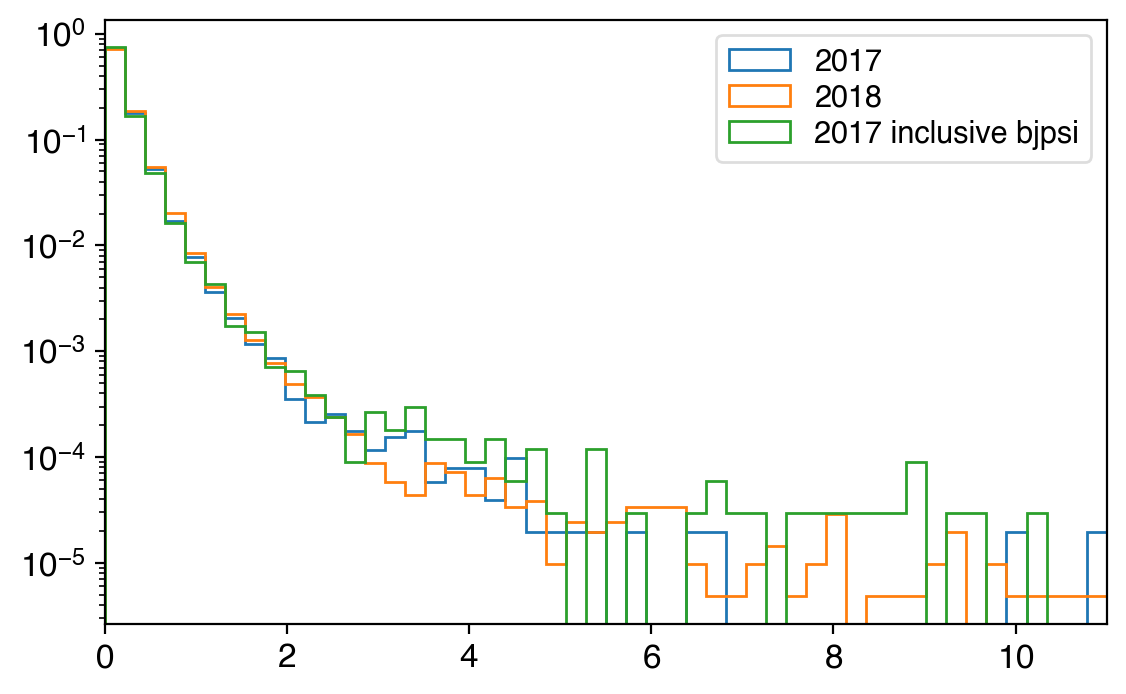

In [14]:
varexp, bins = "mass", "50,2.7,3.5"
varexp, bins = "recolxy", "50,0,11"
h17 = Hist1D(hqe(df_bdtojpsi17,varexp,"l1 and hlt"),bins=bins,overflow=False,label="2017")
h18 = Hist1D(hqe(df_bdtojpsi18,varexp,"l1 and hlt"),bins=bins,overflow=False,label="2018")
h17incl = Hist1D(hqe(df_inclbjpsi17,varexp,"l1 and hlt"),bins=bins,overflow=False,label="2017 inclusive bjpsi")
h17.normalize().plot(histtype="step")
h18.normalize().plot(histtype="step")
h17incl.normalize().plot(histtype="step")
plt.gca().set_yscale("log")

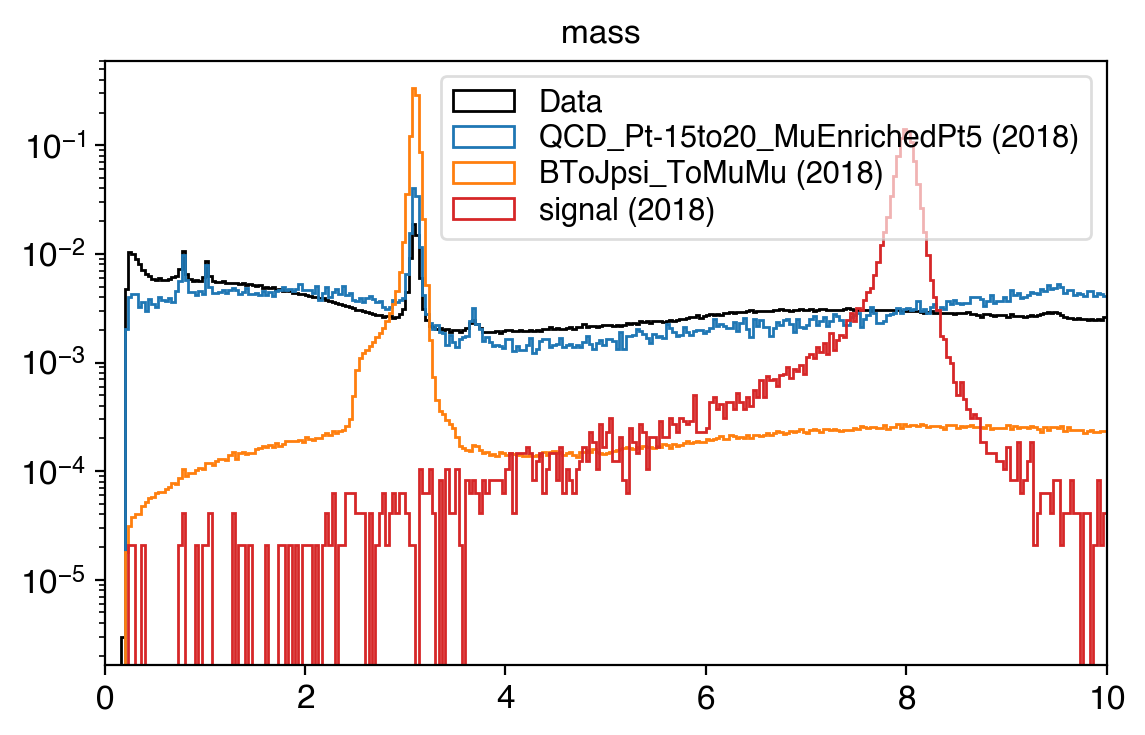

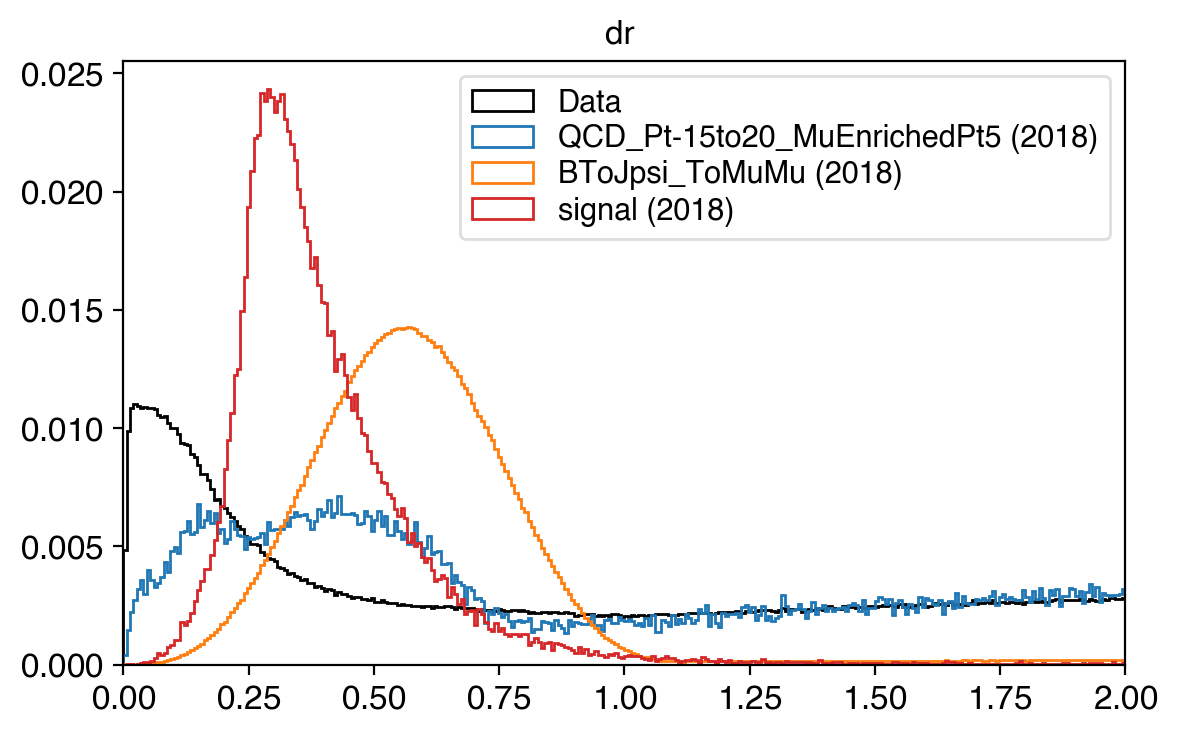

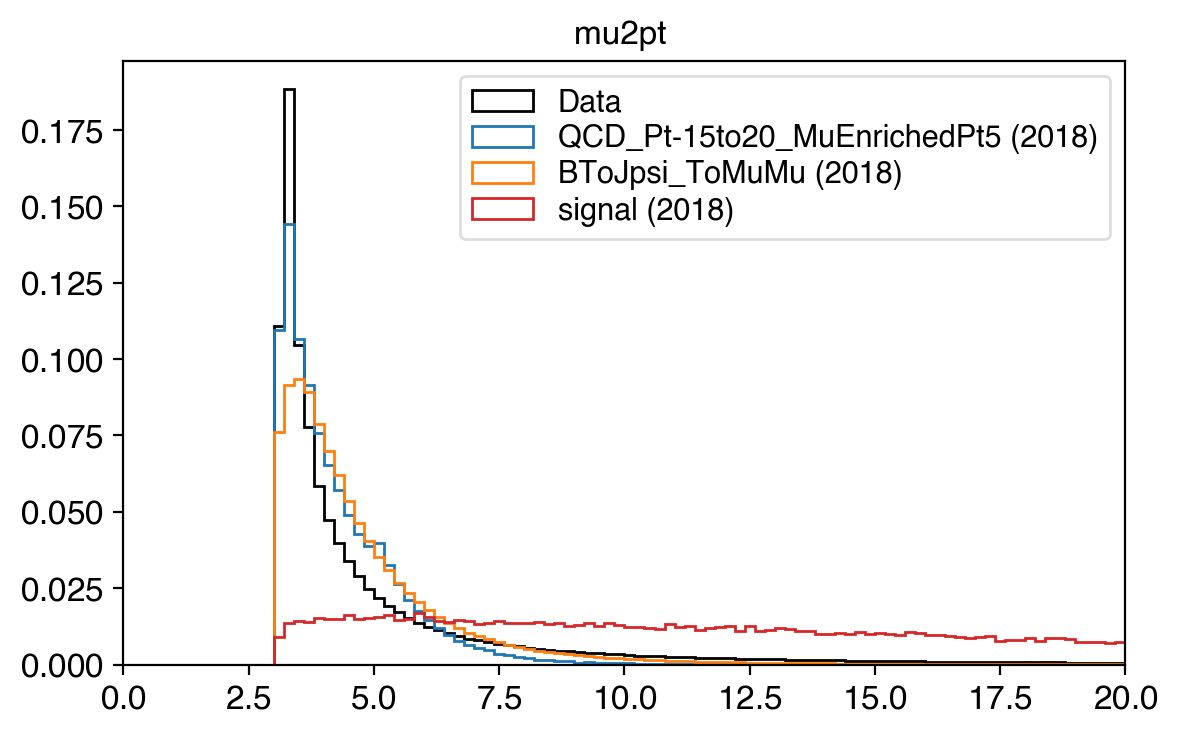

In [15]:
for varexp,sel,bins in [
    ["mass", "", "300,0,10"],
    ["dr", "", "300,0,2.0"],
#     ["mass", "5<mass<12 and dr<2", "50,0,15"],
#     ["dr", "5<mass<12 and dr<2", "50,0,2.0"],
#     ["mass", "2<mass<4 and dr<2", "50,0,10"],
#     ["dr", "2<mass<4 and dr<2", "50,0,2.0"],
    ["mu2pt", "", "100,0,20"],
]:
#     sel = "3.0<mass<3.2"
#     sel = "l1 and hlt"
    fig, ax = plt.subplots()
    
    def hist(df):
        return Hist1D(hqe(df,varexp,sel),bins=bins,overflow=False).normalize()
    
    hist(df_data).plot(ax=ax,histtype="step",color="k",label="Data")
#     hist(df_dy5to50).plot(ax=ax,histtype="step",color="C0",label="DY 5-50")
#     hist(df_dy1to4).plot(ax=ax,histtype="step",color="C1",label="DY 1-4")
#     hist(df_qcdb).plot(ax=ax,histtype="step",color="C2",label="QCD bEnrich")
    hist(df_qcdmu).plot(ax=ax,histtype="step",color="C0",label="QCD_Pt-15to20_MuEnrichedPt5 (2018)")
    hist(df_bjpsi).plot(ax=ax,histtype="step",color="C1",label="BToJpsi_ToMuMu (2018)")
#     hist(df_dp).plot(ax=ax,histtype="step",color="C2",label="Dark photon low mass")
    hist(df_zd).plot(ax=ax,histtype="step",color="C3",label="signal (2018)")
    ax.legend()
    selstr = f"[{sel}]" if sel else ""
    title = f"{varexp} {selstr}"
#     if "<" in varexp:
#         title  = f"min(mu1pt, mu2pt) {selstr}"
    ax.set_title(title)
    if varexp ==  "mass":
        ax.set_yscale("log")

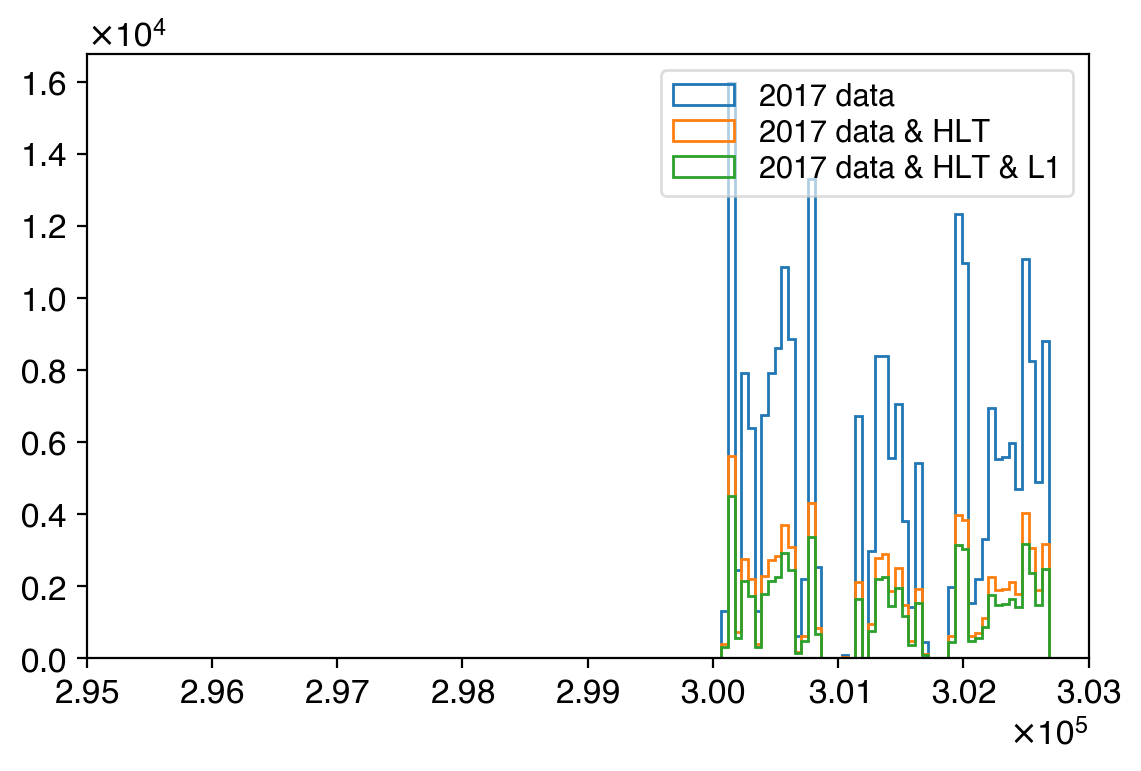

In [16]:
varexp, sel, bins = "run", "run>0", "150,295000,303000"
hden_data17 = Hist1D(hqe(df_data,varexp,sel + " and year==2017"),bins=bins,overflow=False)
hnum_data17 = Hist1D(hqe(df_data,varexp,sel + " and year==2017 and hlt"),bins=bins,overflow=False)
hnum_data17_l1 = Hist1D(hqe(df_data,varexp,sel + " and year==2017 and hlt and l1"),bins=bins,overflow=False)

hden_data17.plot(histtype="step",label="2017 data")
hnum_data17.plot(histtype="step",label="2017 data & HLT")
hnum_data17_l1.plot(histtype="step",label="2017 data & HLT & L1")

In [17]:
df_data[df_data.eval("year==2017 and hlt and l1")]["run"].min()

300087

In [18]:
(df_data["mu1pt"] < df_data["mu2pt"]).sum()

0

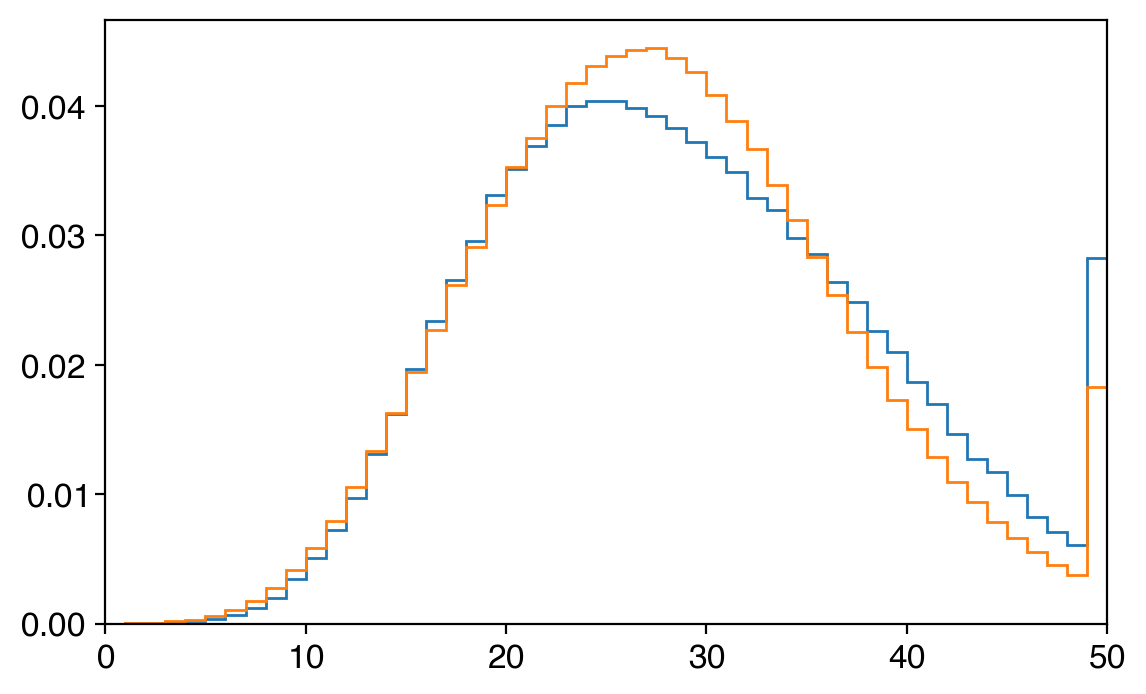

In [19]:
df_data.tree.draw("nvtx","year==2017",bins="50,0,50").normalize().plot(histtype="step")
df_data.tree.draw("nvtx","year==2018",bins="50,0,50").normalize().plot(histtype="step")

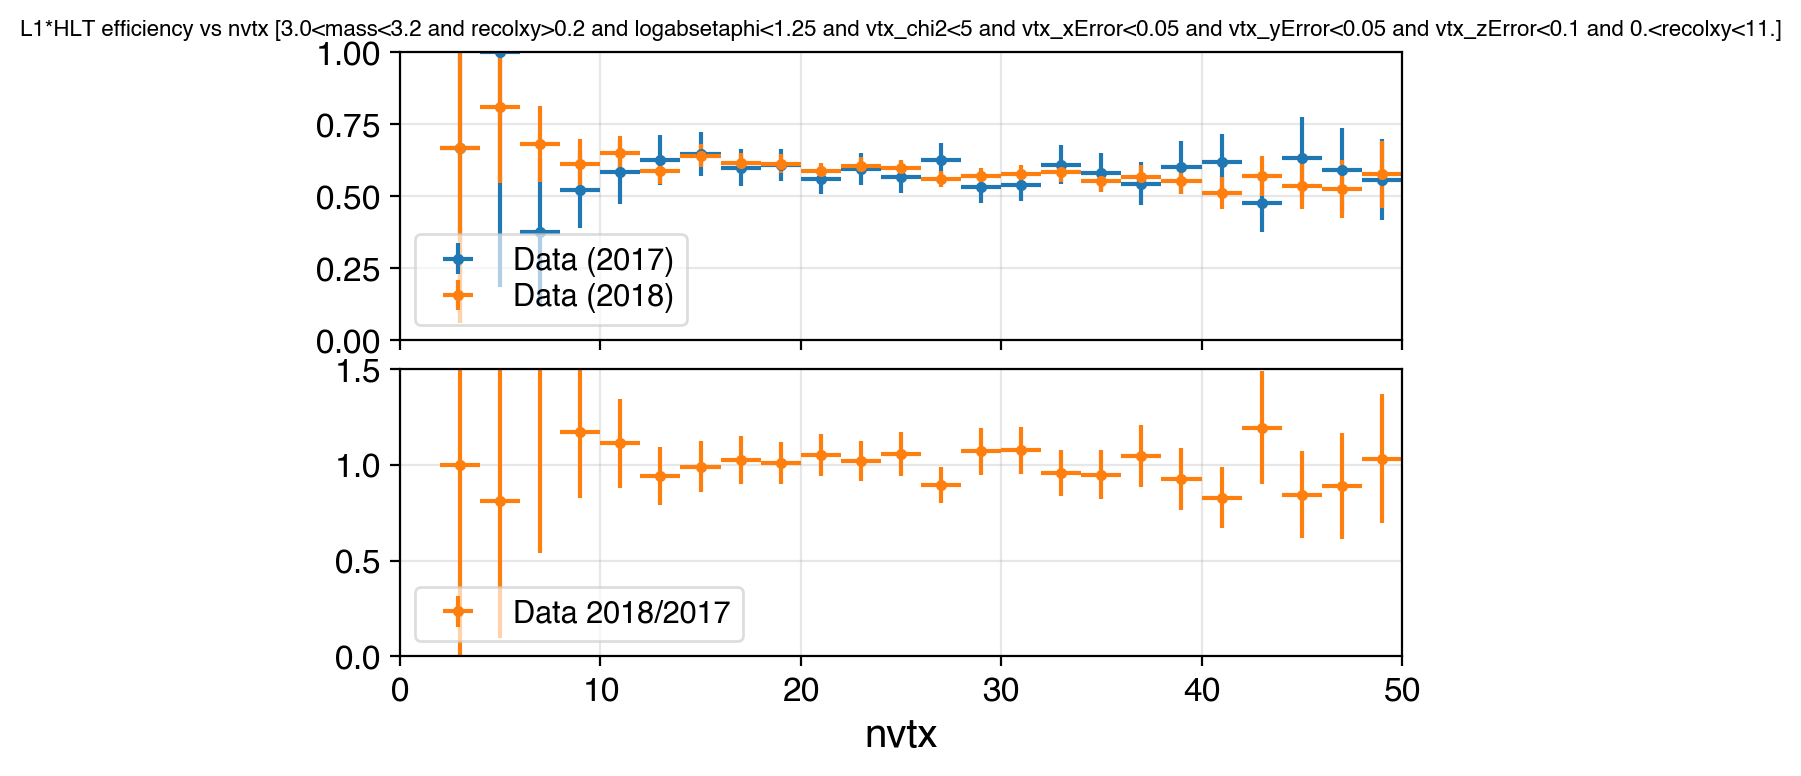

In [20]:
for varexp, sel, bins, label, unit in [
#     ["mass", "0<mass<12", "48,0,12.0", "mass", "GeV"],
#     ["mu2pt", "0<mass<12", "50,0,25.0", "trailing muon $p_T$", "GeV"],
#     ["nvtx", "0<mass<12", "50,0,50.0", "nvtx", ""],
#     ["logabsetaphi", "0<mass<12", "50,-5,5", "logabsetaphi", ""],
    ["nvtx", "3.0<mass<3.2 and recolxy>0.2 and logabsetaphi<1.25 and vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11.", "25,0,50.0", "nvtx", ""],
]:
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)
    hden_data17 = Hist1D(hqe(df_data,varexp,sel + " and year==2017"),bins=bins,overflow=False)
    hnum_data17 = Hist1D(hqe(df_data,varexp,sel + " and year==2017 and hlt and l1"),bins=bins,overflow=False)
    hden_data18 = Hist1D(hqe(df_data,varexp,sel + " and year==2018"),bins=bins,overflow=False)
    hnum_data18 = Hist1D(hqe(df_data,varexp,sel + " and year==2018 and hlt and l1"),bins=bins,overflow=False)

    eff_data17 = (hnum_data17/hden_data17)
    eff_data18 = (hnum_data18/hden_data18)

    eff_data17.plot(ax=ax1,show_errors=True, color="C0", label="Data (2017)", markersize=3)
    eff_data18.plot(ax=ax1,show_errors=True, color="C1", label="Data (2018)", markersize=3)
    
#     if "recolxy" in sel:
#         eff_data17.fit("p0+p1*x",color="C0",ax=ax1)
#         eff_data18.fit("p0+p1*x",color="C1",ax=ax1)
#         ax1.legend(ncol=2, fontsize=7)
#     else:
#         ax1.legend(ncol=2)

    hsf = eff_data18/eff_data17
    hsf.plot(ax=ax2, show_errors=True, label="Data 2018/2017",markersize=3, color="C1")
    if varexp in ["mass"]:
        fit = hsf.fit("p0+p1*x",ax=ax2);
    ax2.legend(ncol=2)
    ax1.set_ylim([0,1])
    ax2.set_ylim([0.0,1.5])

    if unit:
        unit = f" ({unit})"
    ax2.set_xlabel(f"{label}{unit}")
    title = f"L1*HLT efficiency vs {label} [{sel}]"
    ax1.set_title(title, fontsize=(8 if len(title)>50 else 10))

    ax1.grid(alpha=0.3)
    ax2.grid(alpha=0.3)

Text(0.5, 0, 'mass (GeV)')

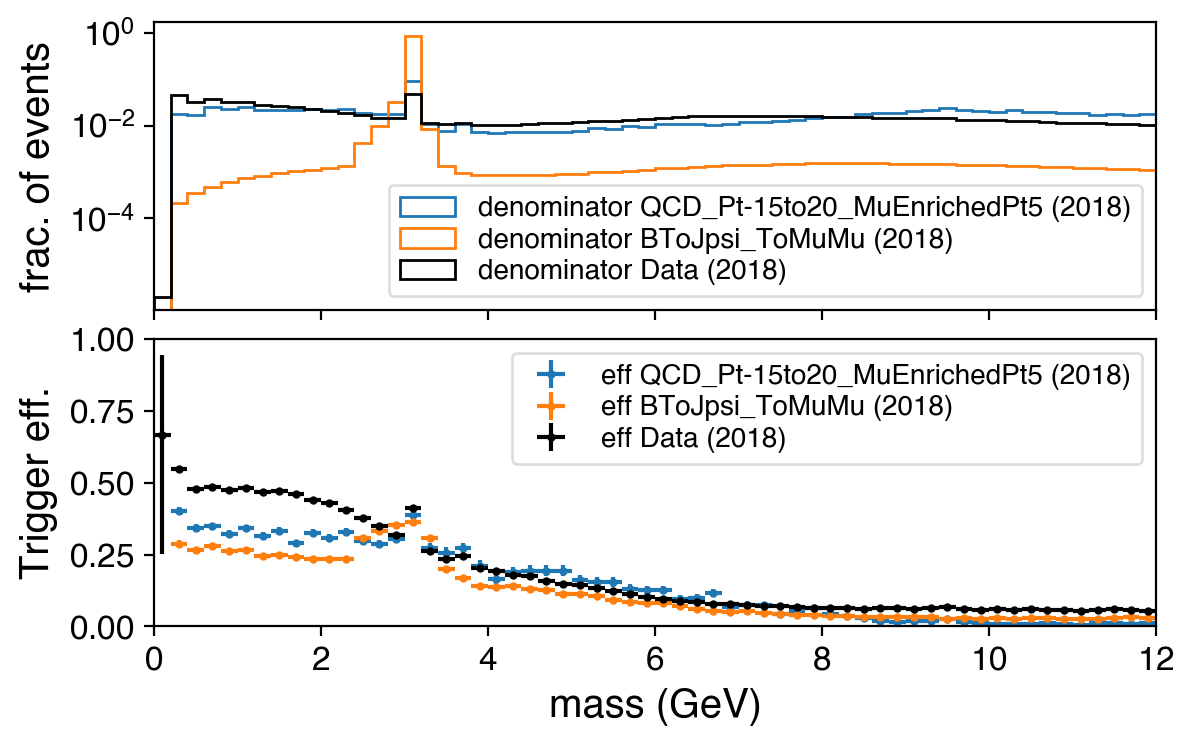

In [21]:
# fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(6,6))
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

# varexp, sel, bins = "dr", "5<mass<12", "20,0,2.0"
# varexp, sel, bins = "dr", "2<mass<4", "40,0,2.0"
varexp, sel, bins = "mass", "0<mass<12", "60,0,12.0"
# varexp, sel, bins = "mu2pt", "0<mass<12", "50,0,25.0"

for color,name,df in [
    ["C0","QCD_Pt-15to20_MuEnrichedPt5 (2018)", df_qcdmu],
    ["C1","BToJpsi_ToMuMu (2018)", df_bjpsi],
#     ["C2","BdJpsi mumu17", df_bdtojpsi17],
#     ["C3","BdJpsi mumu18", df_bdtojpsi18],
#     ["C2","Dark photon low mass", df_dp],
#     ["C3","signal", df_zd],
    ["k","Data (2018)", df_data],
]:
    year = 2018
    if "17" in name: year = 2017
    hden = Hist1D(hqe(df,varexp,sel + f" and year=={year}"),bins=bins,overflow=False)
    hnum = Hist1D(hqe(df,varexp,sel + f" and year=={year} and hlt and l1"),bins=bins,overflow=False)
    

    hden.normalize().plot(ax=ax1, label=f"denominator {name}", color=color, histtype="step")
    
    eff = hnum.divide(hden,binomial=True)
    eff.plot(ax=ax2,show_errors=True, color=color, label=f"eff {name}", markersize=2)
    
    
# eff_data18.plot(ax=ax2,show_errors=True, color="k", label=f"eff Data 2018", markersize=2)
    
    
ax1.legend(fontsize=10,loc="lower right")
ax2.legend(ncol=1,fontsize=10)

ax1.set_ylabel("frac. of events")
ax2.set_ylabel("Trigger eff.")
# ax1.set_ylim([0., None])
ax1.set_yscale("log")
ax2.set_ylim([0,1])
ax2.set_xlabel("mass (GeV)")
# ax2.set_xlabel("Trailing muon $p_T$ (GeV)")


In [22]:
# h = Hist1D(hqe(df_data, "dr", basesel + f" and {selmass} and hlt and l1"), bins="50,0,2.0", label="numer")
# h.plot(histtype="step")
# h = Hist1D(hqe(df_data, "dr", basesel + f" and {selmass}"), bins="50,0,2.0", label="denom")
# h.plot(histtype="step")

# hqe(df_bdtojpsi17, "dr", basesel)

## Dump smaller ntuples to make final efficiency plots

In [14]:
for df in [df_data, df_bdtojpsi17, df_bdtojpsi18]:
    df["vtx_good"] = df.eval("vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11.")

In [15]:
import subprocess
    
code_py = """
import ROOT as r
import math

r.gROOT.ProcessLine(".L ../batch/data/calculate_pixel.cc")

def get_pixel_rectangle_info(px,py,pz):
    rho = math.hypot(px,py)
    if (0.0 < rho < 2.4): return dict()
    if (3.7 < rho < 5.7): return dict()
    imodule = r.point_in_which_module(px, py, pz)
    return dict(
            imodule = imodule,
            planedist = r.dist_to_imodule_plane(px, py, pz, imodule),
            layernum = r.imodule_to_layernum(imodule),
            )

fh_in = open("temp_input.csv", "r")
fh_out = open("temp_output.csv", "w")

fh_out.write("vtx_x,vtx_y,vtx_z,distPixel,pass_materialveto\\n")

for line in fh_in.readlines():
    vx, vy, vz = list(map(float, line.strip().split(",")))
    pixinfo = get_pixel_rectangle_info(vx,vy,vz)
    distPixel = pixinfo.get("planedist",999.)
    pass_materialveto = (distPixel > 0.05)
    fh_out.write("{},{},{},{},{}\\n".format(vx, vy, vz, distPixel, pass_materialveto))
"""

code_sh = """
source /cvmfs/cms.cern.ch/cmsset_default.sh
cd /cvmfs/cms.cern.ch/slc6_amd64_gcc700/cms/cmssw/CMSSW_10_5_0/
eval `scramv1 runtime -sh`
cd -
python temp_script.py
"""

with open("temp_script.py", "w") as fh:
    fh.write(code_py)
with open("temp_script.sh", "w") as fh:
    fh.write(code_sh)
os.system("chmod u+x temp_script.sh")
    
    
    
for df in [
    df_bdtojpsi17,
    df_bdtojpsi18,
    df_data,
]:
    df[["vtx_x","vtx_y","vtx_z"]].to_csv("temp_input.csv", index=False, header=False)
    print(subprocess.getoutput("./temp_script.sh"))
    df["pass_materialveto"] = pd.read_csv("temp_output.csv")["pass_materialveto"].values

**** Following environment variables are going to be unset.
       COMPILER_RUNTIME_OBJECTS
/home/users/namin/2019/scouting/repo/analysis
**** Following environment variables are going to be unset.
       COMPILER_RUNTIME_OBJECTS
/home/users/namin/2019/scouting/repo/analysis
**** Following environment variables are going to be unset.
       COMPILER_RUNTIME_OBJECTS
/home/users/namin/2019/scouting/repo/analysis


In [16]:
cols = ["vtx_good",
        "mu1pt","mu2pt",
        "mu1phi","mu2phi",
        "mu1eta","mu2eta",
        "mu1dxy","mu2dxy",
        "nvtx",
        "mass","year","l1","hlt","recolxy","dr","pass_materialveto"]

print(df_data[df_data["vtx_good"]][cols].memory_usage().sum()*1e-6)

!mkdir -p trig_eff_ntuples/
utils.dataframe_to_ttree(df_data[df_data["vtx_good"]][cols], "trig_eff_ntuples/data.root")
utils.dataframe_to_ttree(df_bdtojpsi17[df_bdtojpsi17["vtx_good"]][cols], "trig_eff_ntuples/mc17.root")
utils.dataframe_to_ttree(df_bdtojpsi18[df_bdtojpsi18["vtx_good"]][cols], "trig_eff_ntuples/mc18.root")
!ls -lrth trig_eff_ntuples/

66.85884



total 74M
-rw-rw-r--+ 1 namin namin  43M Oct 22  2020 data.root
-rw-rw-r--+ 1 namin namin 5.6M Oct 22  2020 mc17.root
-rw-rw-r--+ 1 namin namin  26M Oct 22  2020 mc18.root


In [113]:
!pwd

/home/users/namin/2019/scouting/repo/analysis


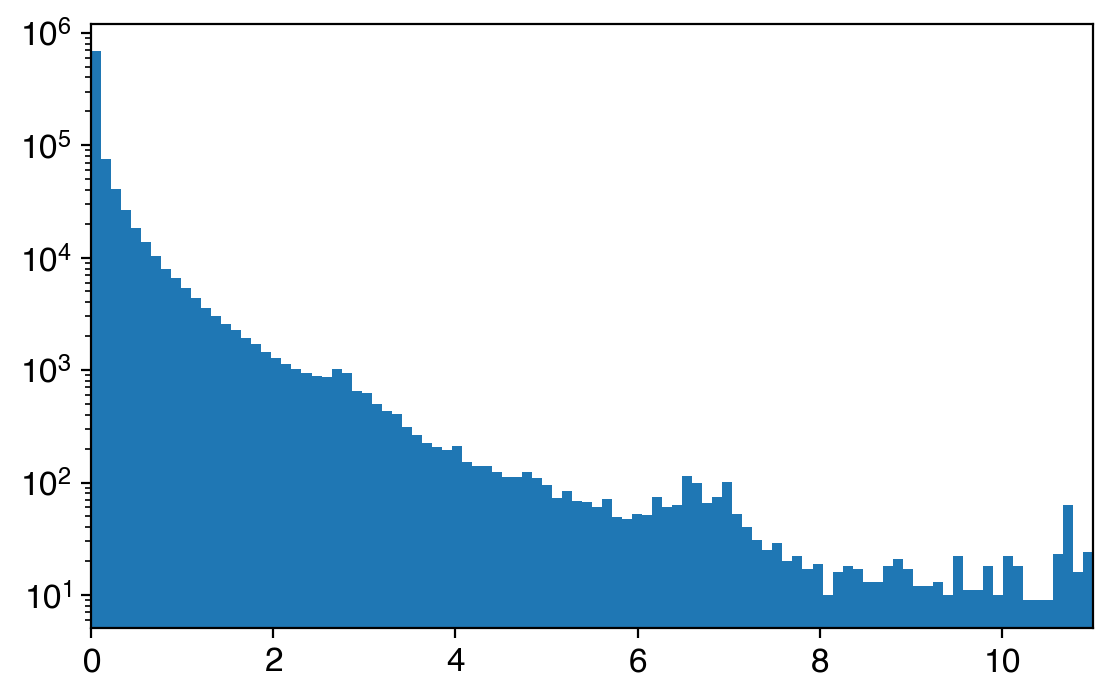

In [30]:
fig, ax = plt.subplots()
Hist1D(df_data[df_data["vtx_good"]]["recolxy"],bins="100,0,11").plot()
ax.set_yscale("log")

0         True
1         True
2         True
3         True
4         True
          ... 
138642    True
138643    True
138644    True
138645    True
138646    True
Name: pass_materialveto, Length: 138647, dtype: bool

Text(0.5, 1.0, '3.0<mass<3.2')

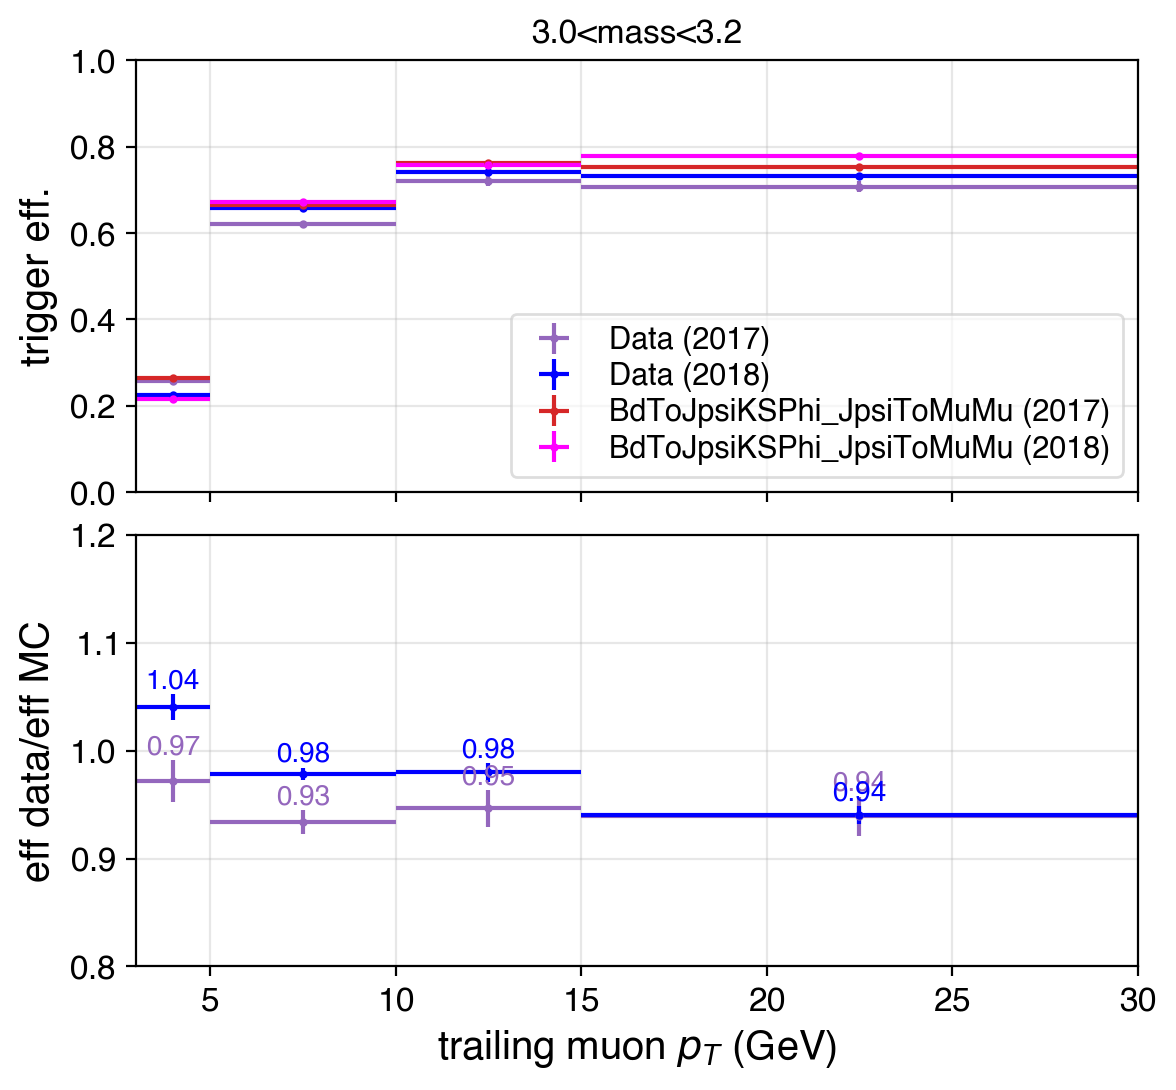

In [43]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,6))

# basesel = "vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11."
basesel = "vtx_good"
basesel += " and mu1pt>3 and mu2pt>3"
selmass = "3.0<mass<3.2"

varexp = "recolxy"
do_reweight_pt = True
bins = [0,0.25,1.,2.4,3.1,5,11]

varexp = "mu2pt"
do_reweight_pt = True
bins = [3.,5.,10.,15,30]

# varexp = "dr"
# do_reweight_pt = True
# bins = [0.,0.2,0.4,0.6,1.2]

dfmcs = dict()
dfmcs[2017] = df_bdtojpsi17
dfmcs[2018] = df_bdtojpsi18

if do_reweight_pt:
    ptbins = np.concatenate([np.arange(3,10), np.arange(10,18,2), np.array([18,300])])
    for year in [2017, 2018]:
        df = dfmcs[year]
        h1 = Hist1D(hqe(df_data,"mu2pt",basesel + f" and {selmass} and year=={year}"),bins=ptbins).normalize()
        h2 = Hist1D(hqe(df,"mu2pt",basesel + f" and {selmass} and year=={year}"),bins=ptbins).normalize()
        hsf = h1/h2
        df["weights"] = hsf.counts[np.digitize(df["mu2pt"], hsf.edges)-1]
        dfmcs[year] = df
else:
    for year in [2017, 2018]:
        dfmcs[year]["weights"] = 1.

heffmcs = dict()
for year in [2017, 2018]:
    df = dfmcs[year]
    df = df[df.eval(basesel + f" and {selmass} and year=={year}")]
    hden = Hist1D(df[varexp],weights=df["weights"],bins=bins)
    df = df[df.eval(basesel + f" and {selmass} and year=={year} and hlt and l1")]
    hnum = Hist1D(df[varexp],weights=df["weights"],bins=bins)
    heffmcs[year] = hnum.divide(hden,binomial=True)

selmass = "3.0<mass<3.2"

heffdatas = dict()
for year in [2017, 2018]:
    hden = Hist1D(hqe(df_data,varexp,basesel + f" and {selmass} and year=={year}"),bins=bins)
    hnum = Hist1D(hqe(df_data,varexp,basesel + f" and {selmass} and year=={year} and hlt and l1"),bins=bins)
    heffdatas[year] = hnum.divide(hden,binomial=True)

ax=ax1
for year in [2017, 2018]:
    color = {2017:"C4",2018:"b"}[year]
    heffdatas[year].plot(ax=ax,show_errors=True,color=color, label=f"Data ({year})", markersize=2)
for year in [2017, 2018]:
    color = {2017:"C3",2018:"magenta"}[year]
    heffmcs[year].plot(ax=ax,show_errors=True,color=color, label=f"BdToJpsiKSPhi_JpsiToMuMu ({year})", markersize=2)
ax.legend()
ax.set_ylabel("trigger eff.")
ax.grid(alpha=0.3)
ax.set_ylim([0.0,1.0])

ax=ax2
for year in [2017, 2018]:
    color = {2017:"C4",2018:"b"}[year]
    (heffdatas[year]/heffmcs[year]).plot(ax=ax,show_errors=True,color=color, markersize=2, show_counts=True, counts_fmt_func="{:.2f}".format)
ax.grid(alpha=0.3)
ax.set_ylim([0.8,1.2])
ax.set_ylabel("eff data/eff MC")
xlabel = {
    "recolxy": "reco lxy (cm)",
    "mu2pt": "trailing muon $p_T$ (GeV)",
    "dr": "$\Delta R$",
}.get(varexp,"")
ax.set_xlabel(xlabel)

ax1.set_title(selmass)

Text(0.5, 0, 'lxy (cm)')

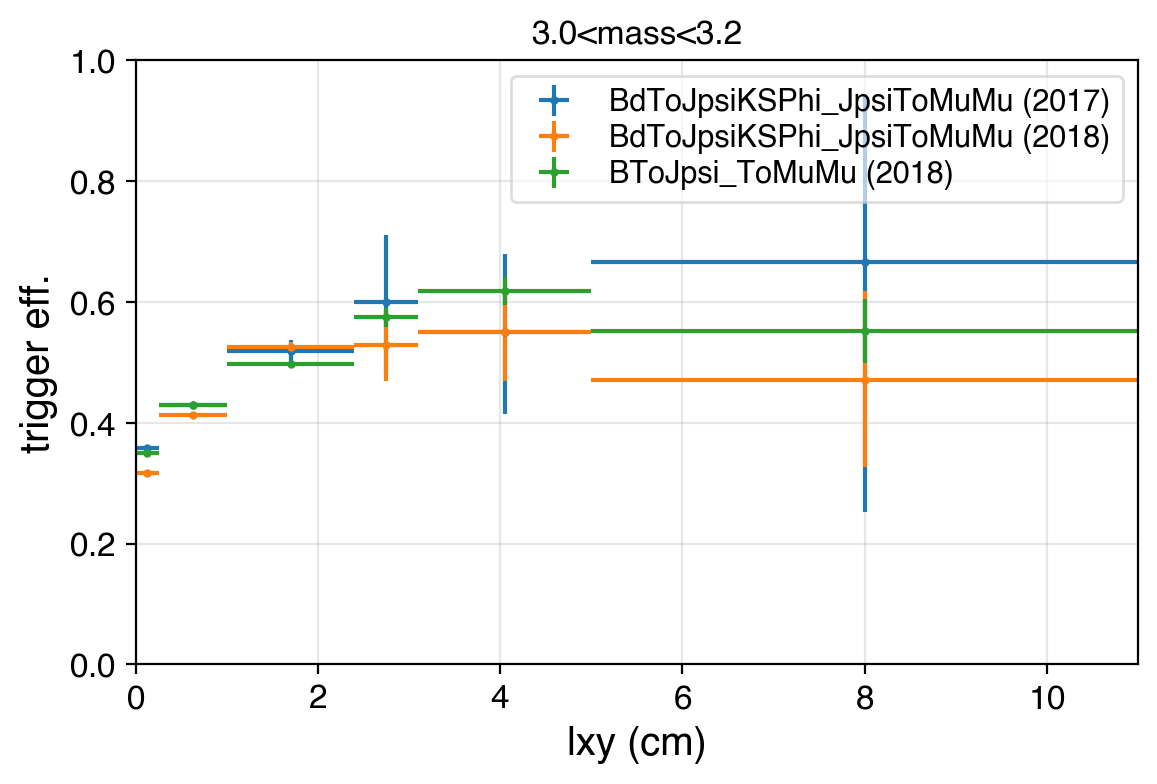

In [25]:
fig, ax = plt.subplots()

basesel = "vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11."
bins = [0,0.25,1.,2.4,3.1,5,11]

df = df_bdtojpsi17
selmass = "3.0<mass<3.2"
hden = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2017"),bins=bins)
hnum = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2017 and hlt and l1"),bins=bins)
heffmc17 = hnum.divide(hden,binomial=True)

df = df_bdtojpsi18
hden = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2018"),bins=bins)
hnum = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2018 and hlt and l1"),bins=bins)
heffmc18 = hnum.divide(hden,binomial=True)

df = df_bjpsi
hden = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2018"),bins=bins)
hnum = Hist1D(hqe(df,"recolxy",basesel + f" and {selmass} and year==2018 and hlt and l1"),bins=bins)
heffmc18_incl = hnum.divide(hden,binomial=True)

heffmc17.plot(ax=ax,show_errors=True,color="C0", label="BdToJpsiKSPhi_JpsiToMuMu (2017)", markersize=2)
heffmc18.plot(ax=ax,show_errors=True,color="C1", label="BdToJpsiKSPhi_JpsiToMuMu (2018)", markersize=2)
heffmc18_incl.plot(ax=ax,show_errors=True,color="C2", label="BToJpsi_ToMuMu (2018)", markersize=2)
ax.legend()
ax.set_ylabel("trigger eff.")
ax.grid(alpha=0.3)
ax.set_ylim([0.0,1.0])
ax.set_title(selmass)
ax.set_xlabel("lxy (cm)")


Text(0.5, 1.0, 'Data')

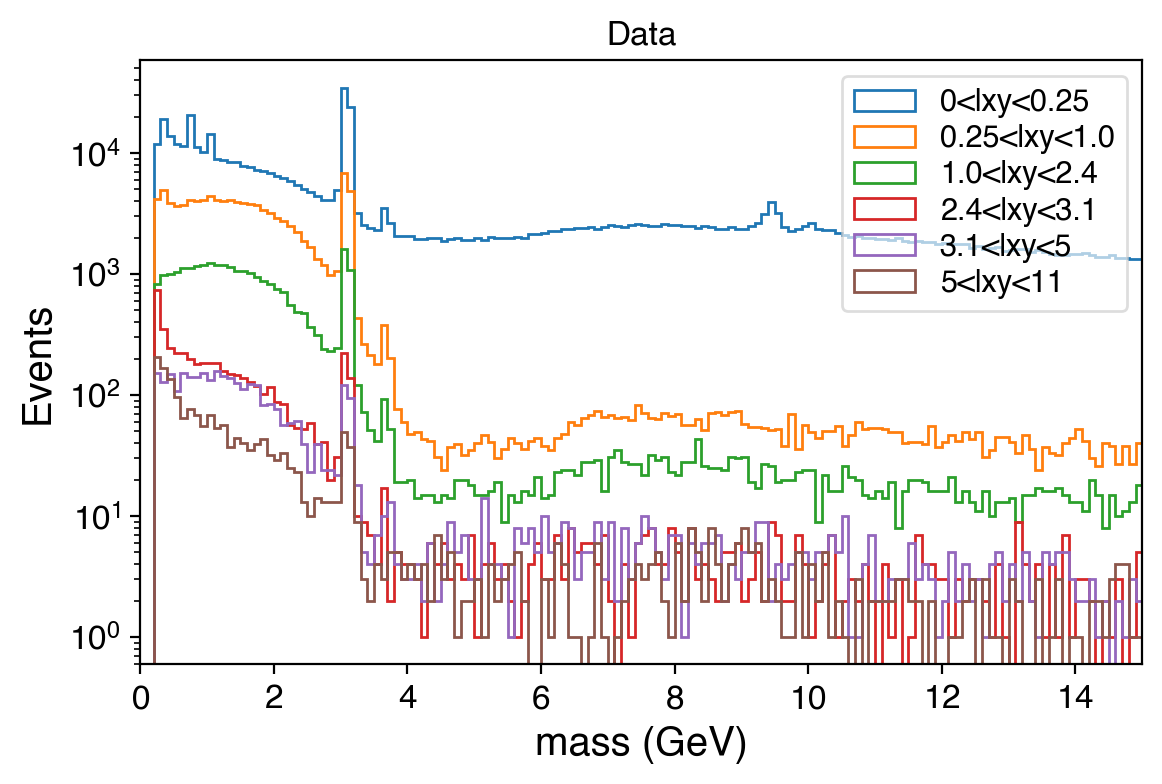

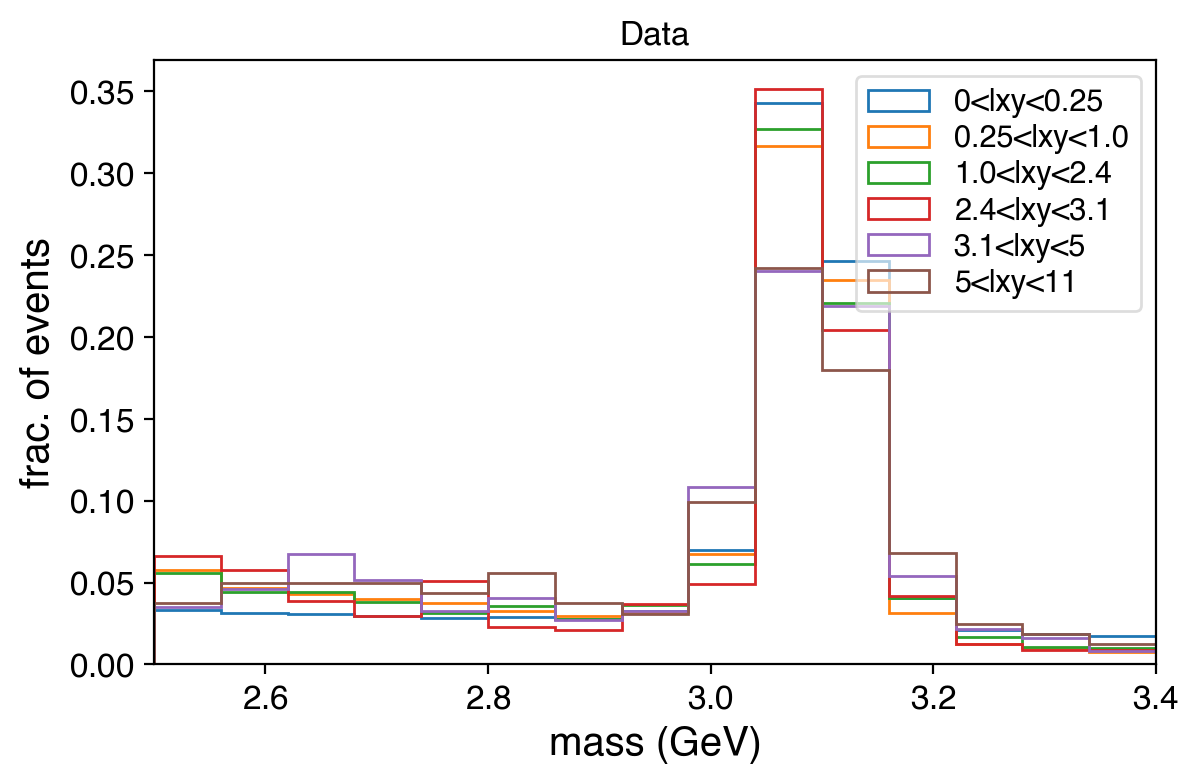

In [26]:
fig,ax=plt.subplots()
df = df_data
lxybins = [0,0.25,1.,2.4,3.1,5,11]
for lxylow,lxyhigh in zip(lxybins[:-1],lxybins[1:]):
    h = Hist1D(hqe(df,"mass",basesel + f"and 0<mass<15 and {lxylow}<recolxy<{lxyhigh}"),bins="150,0,15")
    h.plot(ax=ax,histtype="step",label=f"{lxylow}<lxy<{lxyhigh}")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Events")
ax.set_xlabel("mass (GeV)")
ax.set_title("Data")

fig,ax=plt.subplots()
df = df_data
lxybins = [0,0.25,1.,2.4,3.1,5,11]
for i,(lxylow,lxyhigh) in enumerate(zip(lxybins[:-1],lxybins[1:])):
    color = f"C{i}"
    h = Hist1D(hqe(df,"mass",basesel + f"and 2.5<mass<3.4 and {lxylow}<recolxy<{lxyhigh}"),bins="15,2.5,3.4")
    h = h.normalize()
    h.plot(ax=ax,histtype="step",label=f"{lxylow}<lxy<{lxyhigh}")
ax.set_ylabel("frac. of events")
ax.set_xlabel("mass (GeV)")
ax.set_title("Data")

Text(0.5, 0, 'trailing muon pt')

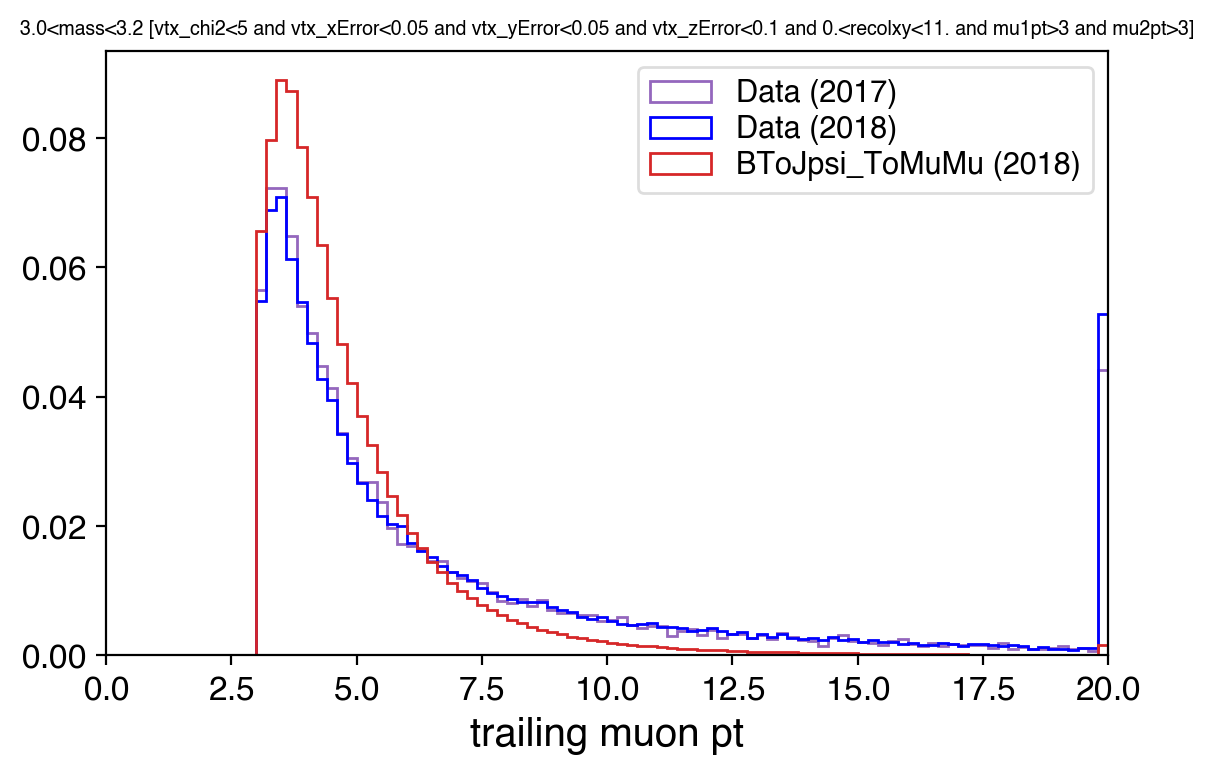

In [27]:
basesel = "vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11."
basesel += " and mu1pt>3 and mu2pt>3"
# bins = [0,0.25,1.,2.4,3.1,5,11]
bins = "100,0,20"
fig, ax = plt.subplots()
# bins = [0,0.1,0.25,0.5,0.75,1.0,1.5,2.5,11.]
# df = df_zd
# df = df_bdtojpsi17
# df = df_bdtojpsi18
# df = df_qcdmu
# df = df_dp
# selmass = "mass>0"
selmass = "3.0<mass<3.2"
df = df_data
Hist1D(hqe(df,"mu2pt",basesel + f" and {selmass} and year==2017"),bins=bins,label="Data (2017)").normalize().plot(
    color="C4",
    histtype="step",
)
Hist1D(hqe(df,"mu2pt",basesel + f" and {selmass} and year==2018"),bins=bins,label="Data (2018)").normalize().plot(
    color="b",
    histtype="step",
)
df = df_bjpsi
df = df[df.eval(basesel + f" and {selmass} and year==2018")]
w = df["weights"]
w = np.ones(len(df))
Hist1D(df["mu2pt"],weights=w,bins=bins,label="BToJpsi_ToMuMu (2018)").normalize().plot(
    color="C3",
    histtype="step",
)
ax.set_title(f"{selmass} [{basesel}]",fontsize=7)
ax.set_xlabel("trailing muon pt")

In [28]:
basesel = "vtx_chi2<5 and vtx_xError<0.05 and vtx_yError<0.05 and vtx_zError<0.1 and 0.<recolxy<11."

ptbins = np.concatenate([np.arange(3,10), np.arange(10,18,2), np.array([18,300])])

selmass = "3.0<mass<3.2"
h1 = Hist1D(hqe(df_data,"mu2pt",basesel + f" and {selmass} and year==2018"),bins=ptbins).normalize()
h2 = Hist1D(hqe(df_bjpsi,"mu2pt",basesel + f" and {selmass} and year==2018"),bins=ptbins).normalize()

hsf = h1/h2
df_bjpsi["weights"] = hsf.counts[np.digitize(df_bjpsi["mu2pt"], hsf.edges)-1]

In [29]:
df_bjpsi.head()[["mu2pt","weights"]]

,mu2pt,weights
0,3.148365,0.775923
1,3.123133,0.775923
2,6.779277,1.020983
3,3.585623,0.775923
4,4.504047,0.695134


In [30]:
# from yahist.utils import expr_to_lambda
# f = expr_to_lambda("const+lin*x+quad*x**2 + norm*np.exp(-(x-mu)**2./(2*sigma**2))")
# print(res["parvalues"][:3])
# f(h.bin_centers,*res["parvalues"][:3],0,0,0)

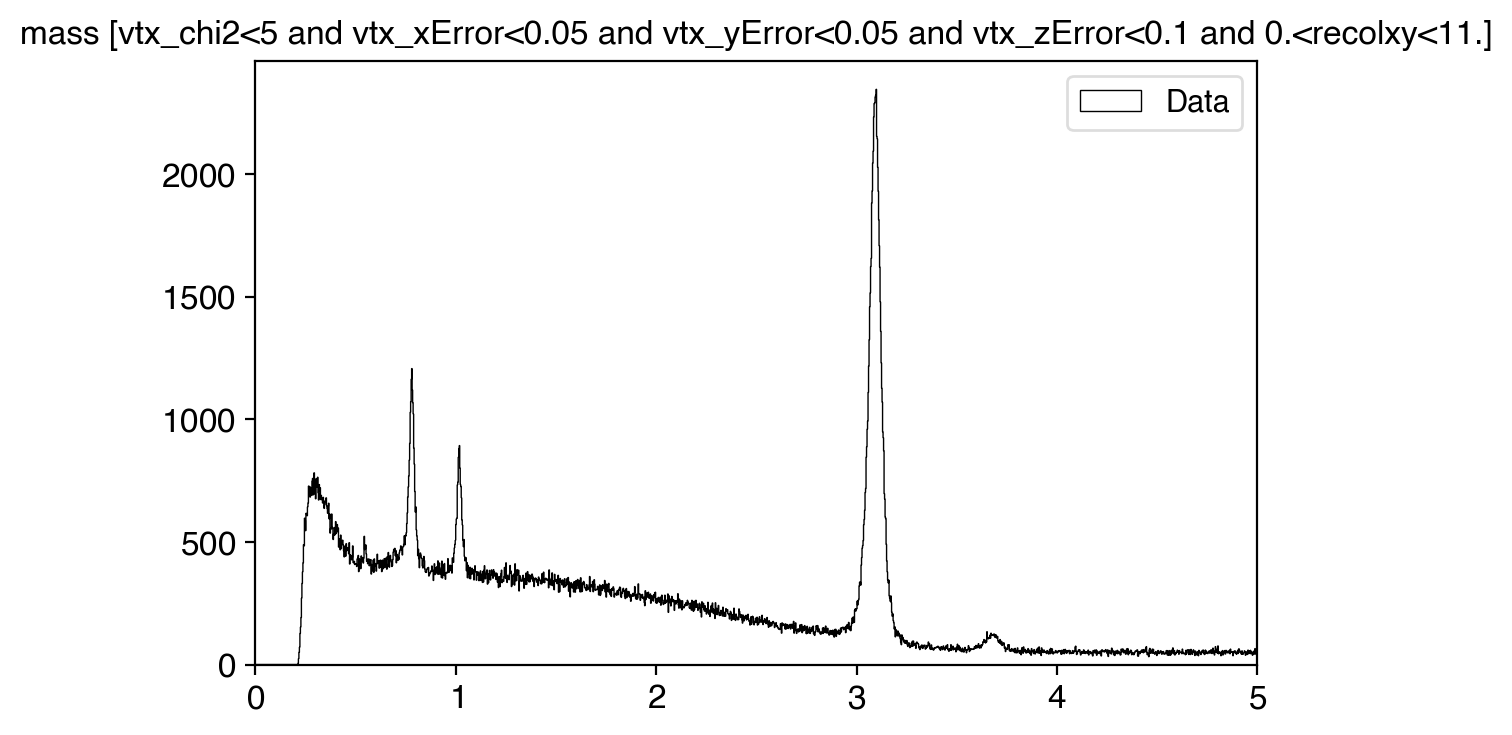

In [31]:
for varexp,sel,bins in [
    ["mass", f"{basesel}", "2000,0,5"],
#     ["mass", f"{basesel}", "100,8,11"],
]:
    fig, ax = plt.subplots()
    h = Hist1D(hqe(df_data,varexp,sel),bins=bins,overflow=False)
    h.plot(ax=ax,histtype="step",color="k",label="Data",lw=0.5)
    ax.legend()
    selstr = f"[{sel}]" if sel else ""
    ax.set_title(f"{varexp} {selstr}")
#     ax.set_xscale("log")
#     ax.set_yscale("log")

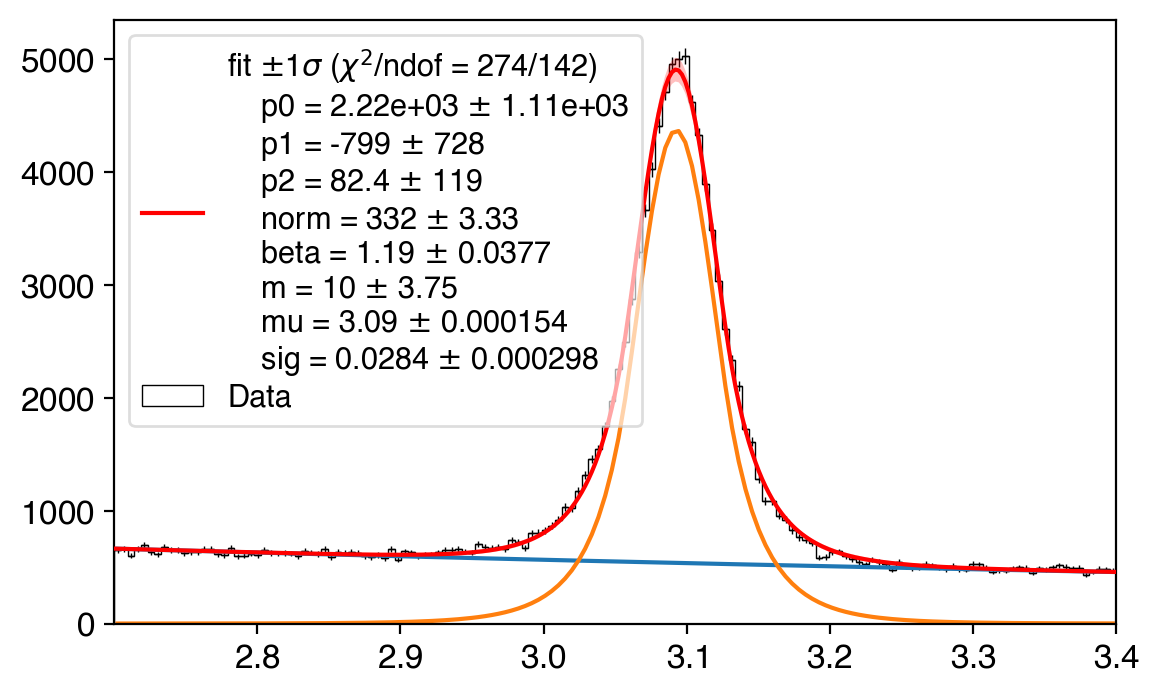

In [32]:
from scipy.stats import crystalball
from ipywidgets import interact
def lindscb(x, p0, p1, p2, norm, beta, m, mu, sig):
    output = x*0.
    left = (x-mu) < 0
    output[left] = norm*crystalball.pdf(x[left], beta=beta, m=m, loc=mu, scale=sig)
    output[~left] = norm*crystalball.pdf(2*mu-x[~left], beta=beta, m=m, loc=mu, scale=sig)
    output += p0+p1*x+p2*x**2
    return output
    
fig, ax = plt.subplots()

sel = ""
bins = "150,2.7,3.4"
# bins = "150,1.5,4.5"
h = Hist1D(hqe(df_data,"mass",sel),bins=bins,overflow=False)
h.plot(ax=ax,histtype="step",color="k",label="Data",lw=0.5)
h.plot(ax=ax,show_errors=True,color="k",lw=0.5,markersize=0.)
# h.fit("a+b*x + c*np.exp(-(x-d)**2./(2*e**2))")
opts=dict(
    p0=[130,-30,0.,34.,1.8,2.8,3.093,0.03],
                bounds=[
    [0, -1e6, -1e6, 0, 0, 1, 2.8, 0.],
    [1e6, 1e6, 1e6, 1e6, 5., 10, 3.3, 1.0],
],
         )
ret = h.fit(lindscb, curve_fit_kwargs=opts)
# ret

# ax.set_yscale("log")

xs = h.bin_centers
from yahist.utils import expr_to_lambda
pars = dict(zip(ret["parnames"],ret["parvalues"]))
ax.plot(xs, pars["p0"]+pars["p1"]*xs+pars["p2"]*xs**2.)
ax.plot(xs, lindscb(xs, 0., 0., 0., pars["norm"], pars["beta"], pars["m"], pars["mu"], pars["sig"]))

In [33]:
ret

parameter,value
p0,2220 ± 1109
p1,-799 ± 728.5
p2,82.44 ± 118.5
norm,331.6 ± 3.33
beta,1.189 ± 0.03767
m,10 ± 3.746
mu,3.093 ± 0.0001542
sig,0.02839 ± 0.0002984


('p0', 'p1') [0.98880353 0.00481654] [0.00626345 0.00157132]
('p0', 'p1') [0.71790459 0.00290612] [0.00422111 0.00110254]
('p0', 'p1') [0.98140101 0.0053168 ] [0.00589192 0.0015451 ]
('p0', 'p1') [0.99629499 0.00798376] [0.0081118  0.00205386]


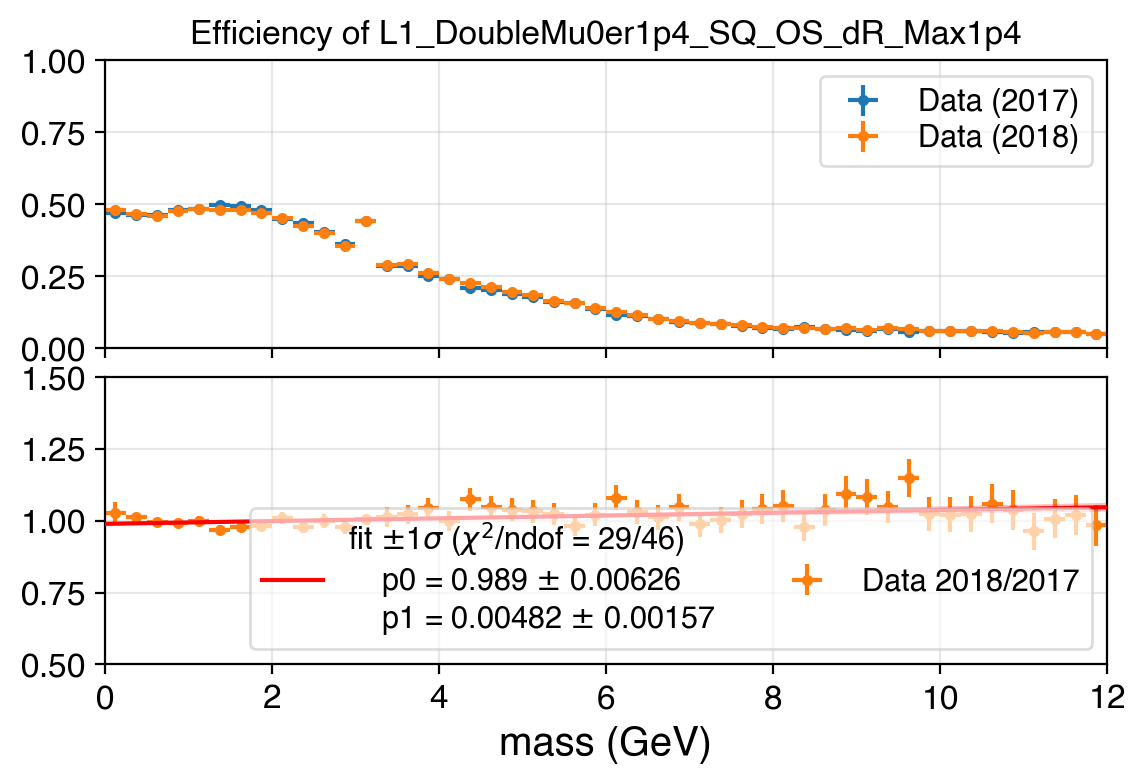

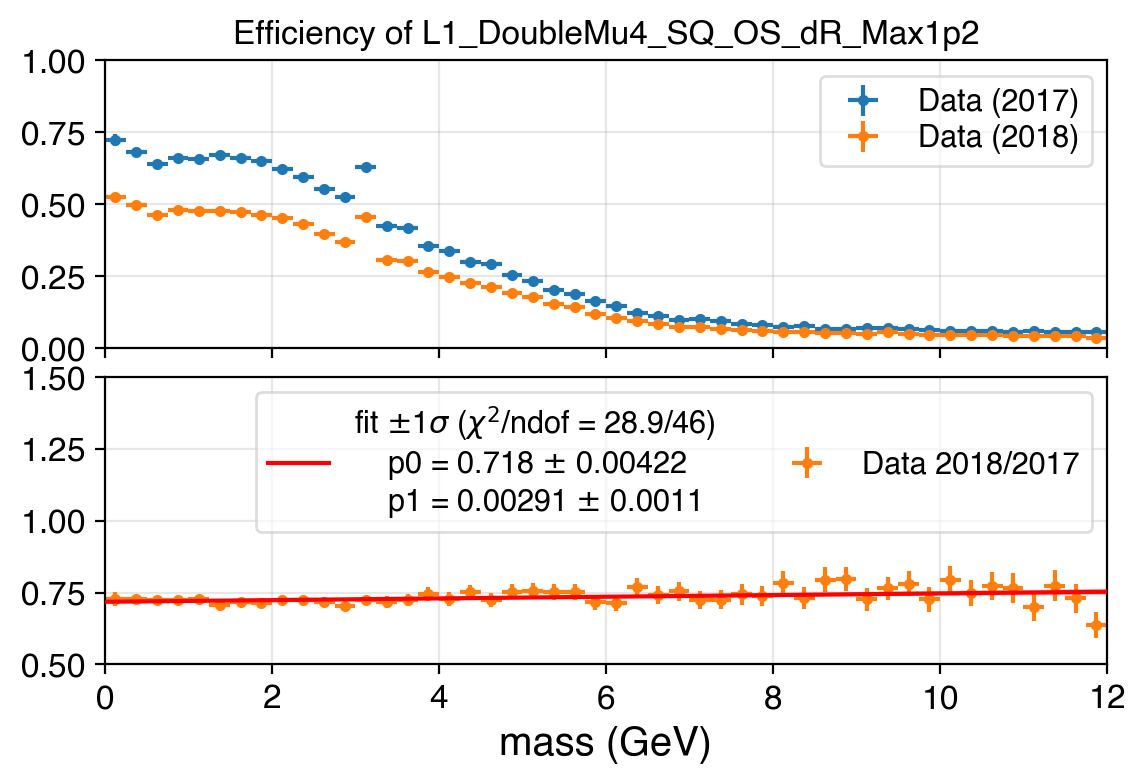

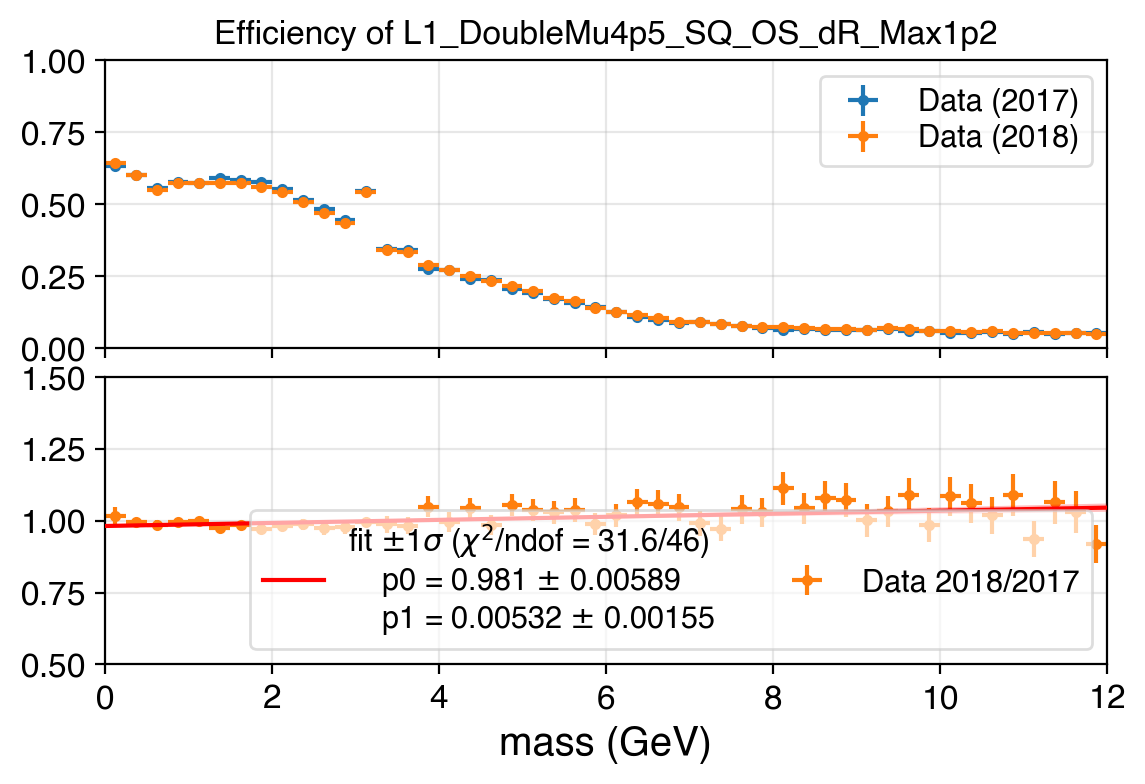

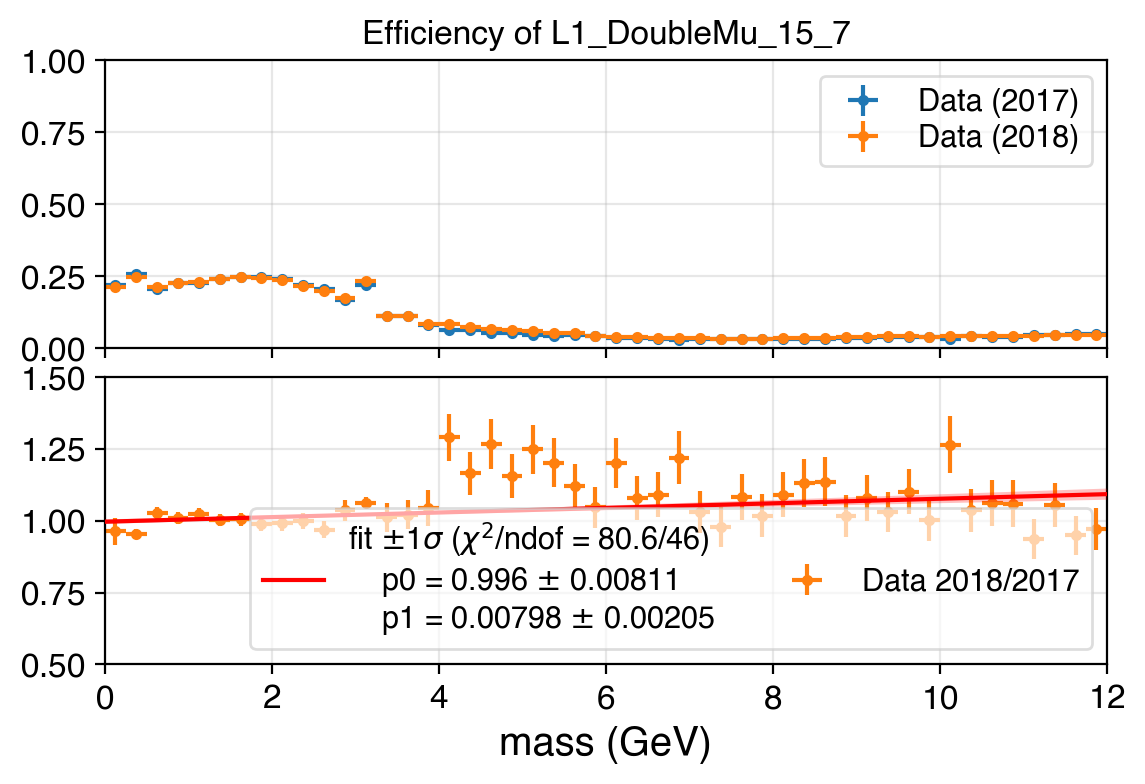

In [34]:
seeds = df_data.columns[df_data.columns.str.startswith("L1")]
for seed in seeds:

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

    varexp, sel, bins = "mass", "0<mass<12", "48,0,12.0"
    seed 
    hden_data17 = Hist1D(hqe(df_data,varexp,sel + f" and year==2017"),bins=bins,overflow=False)
    hnum_data17 = Hist1D(hqe(df_data,varexp,sel + f" and year==2017 and {seed}"),bins=bins,overflow=False)
    hden_data18 = Hist1D(hqe(df_data,varexp,sel + f" and year==2018"),bins=bins,overflow=False)
    hnum_data18 = Hist1D(hqe(df_data,varexp,sel + f" and year==2018 and {seed}"),bins=bins,overflow=False)

    eff_data17 = (hnum_data17/hden_data17)
    eff_data18 = (hnum_data18/hden_data18)

    eff_data17.plot(ax=ax1,show_errors=True, color="C0", label="Data (2017)", markersize=3)
    eff_data18.plot(ax=ax1,show_errors=True, color="C1", label="Data (2018)", markersize=3)

    ax1.legend()

    hsf = eff_data18/eff_data17
    hsf.plot(ax=ax2, show_errors=True, label="Data 2018/2017",markersize=3, color="C1")
    fit = hsf.fit("p0+p1*x",ax=ax2);
    ax2.legend(ncol=2)
    ax1.set_ylim([0,1])
    ax2.set_ylim([0.5,1.5])
    print(fit["parnames"], fit["parvalues"], fit["parerrors"])

    ax1.grid(alpha=0.3)
    ax2.grid(alpha=0.3)
    ax2.set_xlabel("mass (GeV)")
    ax1.set_title(f"Efficiency of {seed}")